In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import math
import yaml
from copy import deepcopy
from numba import jit
rng = np.random.default_rng() # initialize generator instance
from mpl_toolkits import mplot3d # for vizualization
%matplotlib notebook
from time import time
from pathlib import Path

In [114]:
imageParams = { #'sigmaxy'    : np.float_(33.25),
                'sigmaxy'    : np.float_(.007),
                'sigmaz'     : np.float_(4.0),
                'A'          : np.float_(10.0),
                'bkglevel'   : np.float_(0.0),
                'noisestd'   : np.float_(0.0),
                #'pixelsize'  : np.float_(.1067),
                'pixelsize'  : np.float_(.01067),
                'modeloffset': np.float_(90.0)}

In [60]:
class filament():
    def __init__(self, line):
        data = line.split()
        self.gid = data[1]
        dat = np.asarray(data[2:], dtype=np.double)
        self.radius = dat[0]
        self.minus_end = dat[1:4]
        self.plus_end = dat[4:]
        
        self.vec = self.plus_end - self.minus_end
        self.length = np.linalg.norm(self.vec)
        self.orientation = self.vec/self.length
        
        self.theta = -np.arctan2(self.orientation[2], self.orientation[1])
        

In [42]:
def read_dat_sylinder(fname):
    # Read a SylinderAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []  
        
        # Create list of filaments
        filaments = [filament(line) for line in filecontent]    
    return filaments



In [28]:
def GaussianLine2D(x, y, A, sigma, x0, y0, L, theta):
    term0 = (y-y0)*np.cos(theta)+(x0-x)*np.sin(-theta)
    expterm = A*np.exp(-term0*term0/(2*sigma*sigma))
    erfterm = (special.erf((L+(x0-x)*np.cos(theta)+(y0-y)*np.sin(-theta))/(np.sqrt(2)*sigma)) \
             - special.erf(((x0-x)*np.cos(theta)+(y0-y)*np.sin(-theta))/(np.sqrt(2)*sigma)))

    z = expterm*erfterm
    return z

In [103]:
def make_image_bkg(box_dim, image_params):
    pixelSize = image_params['pixelsize']
    noiseStd = image_params['noisestd']
    bkglevel = image_params['bkglevel']

    numPixelsX = np.int_(np.ceil((box_dim[1])/pixelSize))
    numPixelsY = np.int_(np.ceil((box_dim[2])/pixelSize))

    xpixels = np.arange(0,numPixelsX)
    ypixels = np.arange(0,numPixelsY)
    [X,Y] = np.meshgrid(xpixels, ypixels)
    print(bkglevel)

    imagedata = bkglevel * np.ones((numPixelsX, numPixelsY)) + np.random.standard_normal((numPixelsX, numPixelsY))*noiseStd
    print(imagedata)
    return X*pixelSize, Y*pixelSize, imagedata
    

In [104]:
def draw_2d_gauss_filament(X, Y, image_params, fil):
    A = image_params['A']
    sigma = image_params['sigmaxy']
    
    imagedata = GaussianLine2D(X,Y, A, sigma, fil.minus_end[1], fil.minus_end[2], fil.length, fil.theta)
    return imagedata
    

In [81]:
#print "generating microtubule data"
height = 512
pixelSize = imageParams['pixelsize']
noiseStd = imageParams['noisestd']
bkglevel = imageParams['bkglevel']
A = imageParams['A']
sigma = imageParams['sigmaxy']
#offset_distance = imageParams['modeloffset']

numPixelsX = np.int_(np.ceil((height)/pixelSize))
numPixelsY = np.int_(np.ceil((height)/pixelSize))
xpixels = np.arange(0,numPixelsX)
ypixels = np.arange(0,numPixelsY)
[x,y] = np.meshgrid(xpixels, ypixels)

imagedata = bkglevel * np.ones((numPixelsX, numPixelsY)) + np.random.standard_normal((numPixelsX, numPixelsY))*noiseStd

fig, ax = plt.subplots()
ax.set_aspect('equal')
#print "imagedata: {}".format(imagedata)
r0 = np.asarray([25,25])
mlen = 100.
u = np.asarray([2.,1.])
u /= np.linalg.norm(u)
theta = - np.arctan2(u[1], u[0])

derp = GaussianLine2D(x, y, A, sigma, r0[1], r0[0], mlen, theta)
imagedata += derp

r1 = np.asarray([10,50])
mlen1 = 50.
u1 = np.asarray([.5,3.])
u1 /= np.linalg.norm(u)
theta1 = - np.arctan2(u1[1], u1[0])
derp = GaussianLine2D(x, y, A, sigma, r1[1], r1[0], mlen1, theta1)
imagedata += derp


# Loop over microtubules and create the image
#for microtubule in self.microtubules:
#     r0 = microtubule.r - 0.5 * microtubule.v
#     x0 = r0[1]/pixelSize + numPixelsX/2;
#     y0 = r0[2]/pixelSize + numPixelsY/2

#     theta = -np.arctan2(microtubule.u[2], microtubule.u[1])

#     mlen = np.sqrt(microtubule.v[1]*microtubule.v[1] + microtubule.v[2]*microtubule.v[2])/pixelSize

#     derp = GaussianLine2D(x, y, A, sigma, x0, y0, mlen, theta)
#     imagedata = imagedata + derp

#imagedata = np.fliplr(imagedata)

ax.pcolormesh(x,y, imagedata, cmap='gray', vmax=A*5.)
#ax.imshow(imagedata)
# return imagedata


KeyboardInterrupt: 

25600


<IPython.core.display.Javascript object>


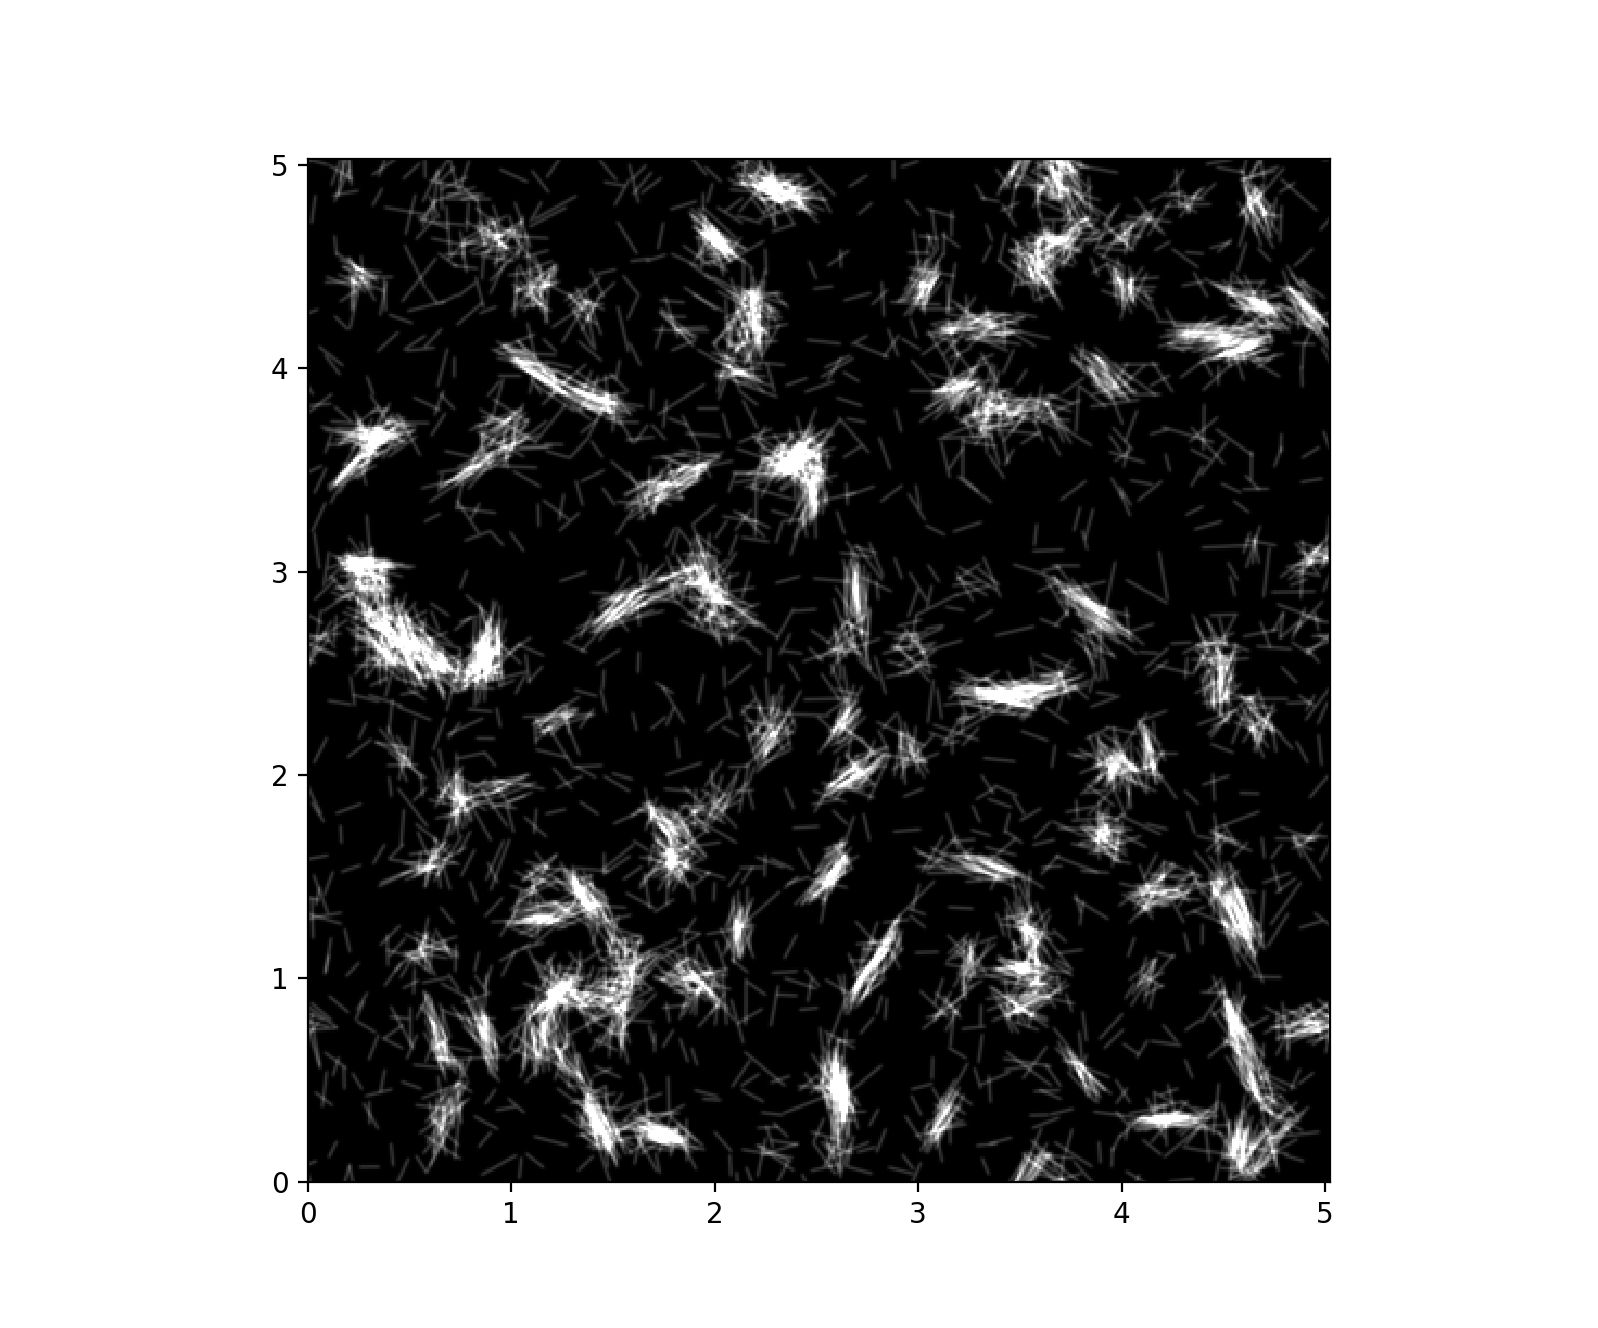

[5.03 5.03 5.03]
0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [118]:
# Try to read data from file
file_name = Path("./TubuleTest.dat")
filaments = read_dat_sylinder(file_name)
print(len(filaments))
fig, ax = plt.subplots()
ax.set_aspect('equal')
with open('TestConfig.yaml', 'r') as yf:
    run_params = yaml.safe_load(yf)
    
sim_box = np.asarray(run_params['simBoxHigh'])
print(sim_box)
X, Y, imagedata = make_image_bkg(sim_box, imageParams)
for fil in filaments[:5000]:
    imagedata += draw_2d_gauss_filament(X, Y, imageParams, fil)

ax.pcolormesh(X, Y, imagedata, cmap='gray', vmax=10.*A)